In [2]:
import os.path as osp

import argparse
import torch
import numpy as np
from torch_geometric.datasets import DBP15K
from matplotlib import pyplot as plt

from manifolds.hyperboloid import Hyperboloid
from hdgmc.hdgmc import RelCNN, HyperbolicRelCNN, HDGMC, HDGMC_ver1
from models.encoders import MyHGCN

from torch_geometric.data import Data, DataLoader


In [33]:
class Args():
    def __init__(self):
        self.category = 'fr_en'
        self.train_size = 1000
        self.dim = 256
        self.rnd_dim = 50
        self.num_layers = 3
        self.num_steps = 10
        self.k = 10
        
args = Args()

args.dim=100
args.rnd_dim=25
args.num_layers=1
args.num_steps=5
args.k=20


In [34]:
class SumEmbedding(object):
    def __call__(self, data):
        data.x1, data.x2 = data.x1.sum(dim=1), data.x2.sum(dim=1)
        return data
    

In [35]:
def train():
    model.train()
    optimizer.zero_grad()
    _, S_L = model(data.x1, data.edge_index1, None, data.x2,
                   data.edge_index2, None, y=train_y)
    
    loss = model.loss(S_L, train_y)
    hits1 = model.acc(S_L, train_y)
    hits10 = model.hits_at_k(10, S_L, train_y)
    
    loss.backward()
    optimizer.step()
    

    return loss, hits1, hits10


@torch.no_grad()
def test():
    model.eval()

    _, S_L = model(data.x1, data.edge_index1, None, data.x2,
                   data.edge_index2, None)
    
    loss = model.loss(S_L, test_y)
    hits1 = model.acc(S_L, test_y)
    hits10 = model.hits_at_k(10, S_L, test_y)

    return loss, hits1, hits10

In [36]:
device = 'cuda:0'
device_1 = 'cuda:0'
device_2 = 'cuda:1'
device_3 = 'cuda:2'
path = osp.join('..', 'data', 'DBP15K')
data = DBP15K(path, args.category, transform=SumEmbedding())[0].to(device)


data.x1 = data.x1 / 10
data.x2 = data.x2 / 10


psi_1 = HyperbolicRelCNN(Hyperboloid(), data.x1.shape[-1], args.dim, 1, args.num_layers, 
               cat='hyp1', lin=True, dropout=0.0, use_bias=True, use_att=False)

psi_2 = HyperbolicRelCNN(Hyperboloid(), args.rnd_dim, args.rnd_dim, 1, 
                         args.num_layers, cat='hyp1', lin=False, dropout=0.0, use_bias=False, use_att=False)

model = HDGMC(psi_1, psi_2, num_steps=None, k=args.k).to(device)
model.multi_gpu(device_1, device_2, device_3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

in: 300, out: 100, c: 1, dropout: 0.0, att: False, bias: True
in channels in lin:  400
in: 25, out: 25, c: 1, dropout: 0.0, att: False, bias: False


In [37]:
hyp = Hyperboloid()


h_s = data.x1
h_t = data.x2

h_s = hyp.proj_tan0(h_s, c=1)
h_s = hyp.expmap0(h_s, c=1)
# h_s = hyp.proj(h_s, c=1)

h_t = hyp.proj_tan0(h_t, c=1)
h_t = hyp.expmap0(h_t, c=1)
# h_t = hyp.proj(h_t, c=1)


norm_s = hyp.minkowski_dot(h_s, h_s)
valid_s = ((norm_s > -1.1) & (norm_s < -0.9)).sum()
valid_s = valid_s.float() / h_s.shape[-2] 

norm_t = hyp.minkowski_dot(h_t, h_t)
valid_t = ((norm_t > -1.1) & (norm_t < -0.9)).sum()
valid_t = valid_t.float() / h_t.shape[-2] 

print('AT THE START')
print(f'on hyperboloid: {valid_s:.02f}, {valid_t:.02f}')
print(f'norms: {norm_s.mean().cpu().detach().numpy().round(2)}, {norm_t.mean().cpu().detach().numpy().round(2)}')

data.x1 = h_s
data.x2 = h_t

train_y = data.train_y
test_y = data.test_y

AT THE START
on hyperboloid: 1.00, 1.00
norms: -1.0, -1.0


In [38]:
loss_history_train, hits1_history_train, hits10_history_train = [], [], []
loss_history_test, hits1_history_test, hits10_history_test = [], [], []

print('Optimize initial feature matching...\n')
model.num_steps = 0
for epoch in range(100):
    if epoch == 50:
        print('Refine correspondence matrix...\n')
        model.num_steps = args.num_steps
        model.detach = True
        for g in optimizer.param_groups:
            g['lr'] = 0.001 / 20

    loss, hits1, hits10 = train()
#     print((f'{epoch:03d}: Loss: {loss:.4f}, Hits@1: {hits1:.4f}, '
#                f'Hits@10: {hits10:.4f}'))
    
    loss_history_train.append(loss)
    hits1_history_train.append(hits1)
    hits10_history_train.append(hits10)

    if epoch % 1 == 0 or epoch == 50 or epoch == 100:
        loss, hits1, hits10 = test()
#         if loss.isnan().item():
#             model.set_verbose(True)
        loss_history_test.append(loss)
        hits1_history_test.append(hits1)
        hits10_history_test.append(hits10)
        
        print((f'{epoch:03d}: Loss: {loss:.4f}, Hits@1: {hits1:.4f}, '
               f'Hits@10: {hits10:.4f}'))
    

Optimize initial feature matching...

000: Loss: 2.2526, Hits@1: 0.6274, Hits@10: 0.6911
001: Loss: 2.3498, Hits@1: 0.6621, Hits@10: 0.7307
002: Loss: 2.3713, Hits@1: 0.6815, Hits@10: 0.7524
003: Loss: 2.3452, Hits@1: 0.6920, Hits@10: 0.7638
004: Loss: 2.2938, Hits@1: 0.6941, Hits@10: 0.7694
005: Loss: 2.2157, Hits@1: 0.6958, Hits@10: 0.7686
006: Loss: 2.1200, Hits@1: 0.6919, Hits@10: 0.7680
007: Loss: 2.0259, Hits@1: 0.6916, Hits@10: 0.7658
008: Loss: 1.9399, Hits@1: 0.6921, Hits@10: 0.7679
009: Loss: 1.8620, Hits@1: 0.6955, Hits@10: 0.7709
010: Loss: 1.8022, Hits@1: 0.6977, Hits@10: 0.7710
011: Loss: 1.7532, Hits@1: 0.7020, Hits@10: 0.7721
012: Loss: 1.7089, Hits@1: 0.7061, Hits@10: 0.7742
013: Loss: 1.6651, Hits@1: 0.7084, Hits@10: 0.7761
014: Loss: 1.6181, Hits@1: 0.7128, Hits@10: 0.7774
015: Loss: 1.5676, Hits@1: 0.7153, Hits@10: 0.7787
016: Loss: 1.5132, Hits@1: 0.7169, Hits@10: 0.7785
017: Loss: 1.4611, Hits@1: 0.7164, Hits@10: 0.7788
018: Loss: 1.4062, Hits@1: 0.7176, Hits@10: 

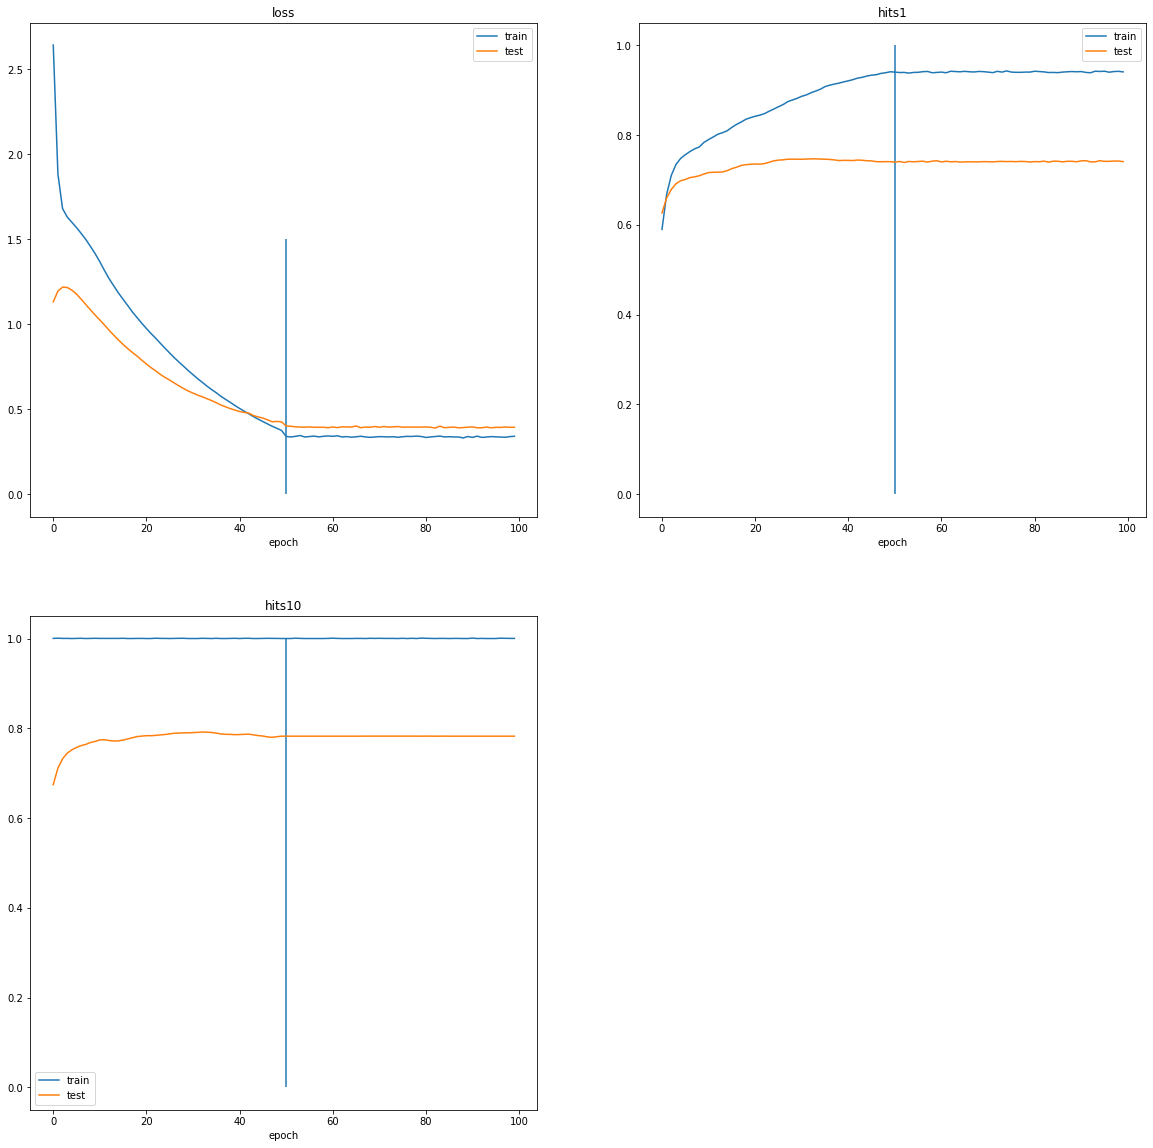

In [32]:
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.plot(loss_history_train, label='train')
plt.plot(loss_history_test, label='test')
plt.title('loss')
plt.xlabel('epoch')
plt.vlines(50, 0, 1.5)
plt.legend()



plt.subplot(2, 2, 2)
plt.plot(hits1_history_train, label='train')
plt.plot(hits1_history_test, label='test')
plt.title('hits1')
plt.xlabel('epoch')
plt.vlines(50, 0, 1)
# plt.ylim(0.55, 0.87)
plt.legend()



plt.subplot(2, 2, 3)
plt.plot(hits10_history_train, label='train')
plt.plot(hits10_history_test, label='test')
plt.title('hits10')
plt.xlabel('epoch')
plt.vlines(50, 0, 1)
plt.legend()

plt.show()